In [241]:
# Cargar librerías necesarias
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

from sklearn.model_selection import train_test_split

# Para visualizar las imágenes
import PIL
from PIL import Image

from sklearn.model_selection import KFold
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint


import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import  Flatten, Dense
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


In [243]:

def aumentarImagenes(img_array, n, plotear=False):
    # Agregar dimensión para batch y asegurar que tenga 4 dimensiones
    if img_array.ndim == 3:  # Si tiene 3 dimensiones (height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)  # Añade dimensión para batch
    elif img_array.ndim == 2:  # Si es en escala de grises (height, width)
        img_array = np.expand_dims(img_array, axis=-1)  # Añade canal de color
        img_array = np.expand_dims(img_array, axis=0)   # Añade dimensión para batch

    # Configuración de ImageDataGenerator para aumentar datos
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    training_set = train_datagen.flow_from_directory(
        './entrenamiento',  
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )


    # Generar imágenes aumentadas
    i = 0
    images = []
    for batch in datagen.flow(img_array, batch_size=1):
        if plotear:
            plt.figure(i)
            plt.imshow(batch[0])
        images.append(batch[0])
        i += 1
        if i >= n:
            break
    if plotear:
        plt.show()

    return images



In [244]:

folder_path = './entrenamiento'

# Listas para almacenar las imágenes y las etiquetas
image_list = []
y = []

# Recorre todos los archivos en la carpeta
for filename in os.listdir(folder_path):
    val = -1  # Valor predeterminado para etiquetas inválidas

    # Determina la etiqueta basándose en el nombre del archivo
    if 'bear' in filename:
        val = 0
    elif 'goat' in filename:
        val = 1
    elif 'wolf' in filename:
        val = 2

    # Solo procesa imágenes y archivos válidos
    if val != -1 and (filename.endswith(".jpg") or filename.endswith(".png")):
        # Añade la etiqueta para la imagen original
        y.append(val)

        # Carga y procesa la imagen
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')  # Asegura que esté en RGB
        img = img.resize((224, 224))  # Redimensiona la imagen
        img_array = np.array(img) / 255.0  # Normaliza la imagen
        image_list.append(img_array)

        # Aumenta la imagen y añade las imágenes aumentadas a la lista
        aumentadas = aumentarImagenes(img_array, 2, plotear=False)
        image_list.extend(aumentadas)

        # Añade las etiquetas correspondientes para cada imagen aumentada
        y.extend([val] * len(aumentadas))

# Verificación de sincronización
if len(image_list) == len(y):
    print("Listas sincronizadas. Total de imágenes y etiquetas:")
    print(f"Total de imágenes: {len(image_list)}")
    print(f"Total de etiquetas: {len(y)}")
else:
    print("Error: El número de imágenes y etiquetas no coincide.")




Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging 

In [251]:
# Convertir las listas en arreglos numpy
X = np.array(image_list)
y = np.array(y)

In [252]:

# Cargar el modelo preentrenado MobileNetV2 sin las capas superiores
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas superiores personalizadas para la clasificación
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback para reducir la tasa de aprendizaje si no mejora el rendimiento
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [254]:
# Convertir la lista de imágenes y etiquetas a arrays numpy
X = np.array(image_list)
y = np.array(y)

# Convertir etiquetas a formato categórico para clasificación
y = to_categorical(y, num_classes=3)

# Cargar el modelo preentrenado MobileNetV2 sin las capas superiores
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas superiores personalizadas para la clasificación
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback para reducir la tasa de aprendizaje si no mejora el rendimiento
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Definir la validación cruzada K-Fold
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Realizar el K-Fold en el conjunto de datos
fold_no = 1
for train_index, val_index in kfold.split(X, y):
    print(f"Training on fold {fold_no}")
    
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Entrenar el modelo
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=15,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[reduce_lr]
    )
    
    print(f"Completed training on fold {fold_no}")
    fold_no += 1

Training on fold 1
Epoch 1/15
20/20 [==============================] - 10s 390ms/step - loss: 7.4328 - accuracy: 0.5008 - val_loss: 2.3790 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - 7s 334ms/step - loss: 1.2656 - accuracy: 0.5737 - val_loss: 1.4798 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - 7s 335ms/step - loss: 0.8741 - accuracy: 0.5816 - val_loss: 1.2019 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 4/15
20/20 [==============================] - 7s 329ms/step - loss: 1.0105 - accuracy: 0.5483 - val_loss: 1.4765 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 5/15
20/20 [==============================] - 7s 339ms/step - loss: 0.8715 - accuracy: 0.5610 - val_loss: 1.7310 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 6/15
20/20 [==============================] - 7s 328ms/step - loss: 1.2518 - accuracy: 0.5578 - val_loss: 1.2411 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 7/15
20/20 [==============================] 

In [255]:

X_train, X_test, y_train, y_test = train_test_split(image_list, y, test_size=0.2, random_state=42, stratify=y)

In [256]:

def crear_modelo():

  model = Sequential()
  model.add(Flatten(input_shape=(224, 224, 3)))  # Aplanar la imagen
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(3, activation='softmax')) #3 es el numero de clases
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [257]:
model.save("modeloEva2.h5")

c:\Users\nob96\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [258]:

X_train = np.array(X_train)
y_train = np.array(y_train)

In [259]:

y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_train

array([[[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]], dtype=float32)

In [260]:

X_train.shape

(631, 224, 224, 3)

In [261]:

y_train

array([[[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]], dtype=float32)

In [262]:

type(y_train)

numpy.ndarray

In [263]:

y_train.shape

(631, 3, 3)

In [265]:

X_test = np.array(X_test)
y_test = np.array(y_test)

In [266]:

if len(y_test.shape) == 0:
    y_test = y_test.reshape(1,)

In [267]:

y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1

In [269]:

y_pred = model.predict(X_test) 

5/5 [==============================] - 2s 225ms/step


In [270]:

y_pred

array([[3.05453598e-01, 4.06827807e-01, 2.87718624e-01],
       [2.94211686e-01, 3.61768395e-01, 3.44019920e-01],
       [3.21058214e-01, 3.53245050e-01, 3.25696707e-01],
       [2.91445136e-01, 4.29739416e-01, 2.78815418e-01],
       [3.20632339e-01, 3.14428985e-01, 3.64938647e-01],
       [1.28827112e-20, 1.25459192e-23, 1.00000000e+00],
       [1.99326155e-06, 9.99997973e-01, 3.85208219e-11],
       [3.14497918e-01, 3.35707605e-01, 3.49794567e-01],
       [1.02040719e-32, 6.57126337e-37, 1.00000000e+00],
       [2.99136072e-01, 3.76559466e-01, 3.24304461e-01],
       [3.12635720e-01, 3.13605845e-01, 3.73758465e-01],
       [3.13343614e-01, 3.84098202e-01, 3.02558213e-01],
       [2.97808886e-01, 3.39145333e-01, 3.63045782e-01],
       [1.90136930e-07, 9.99999762e-01, 2.84719034e-16],
       [3.28767993e-22, 2.45834125e-22, 1.00000000e+00],
       [1.99883971e-07, 9.99999762e-01, 3.69388819e-13],
       [3.15802813e-01, 3.61791700e-01, 3.22405517e-01],
       [1.00000000e+00, 3.74009

In [271]:

y_pred=np.round(y_pred)
y_pred

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0

In [ ]:

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Cálculo de las métricas
accuracy = accuracy_score(y_true, y_pred)

# Calculamos precision, recall y f1 para cada clase
precision = precision_score(y_true, y_pred, average=None)
precision_avg = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average=None)
recall_avg = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average=None)
f1_avg = f1_score(y_true, y_pred, average="macro")

# Imprimir las métricas
print("Exactitud:", accuracy)
print("Precisión por clase:", precision, '->', precision_avg)
print("Sensibilidad por clase:", recall, '->', recall_avg)
print("F1 Score por clase:", f1, '->', f1_avg)


Exactitud: 0.6463878326996197
Precisión por clase: [1.         0.56936416 0.63380282] -> 0.7343889929170399
Sensibilidad por clase: [0.33333333 0.82083333 0.78947368] -> 0.6478801169590643
F1 Score por clase: [0.5        0.67235495 0.703125  ] -> 0.6251599829351536
Métricas por clase:
   Precision  Sensibilidad  F1 Score
0   1.000000      0.333333  0.500000
1   0.569364      0.820833  0.672355
2   0.633803      0.789474  0.703125


25/25 [==============================] - 6s 230ms/step


<Figure size 800x600 with 0 Axes>

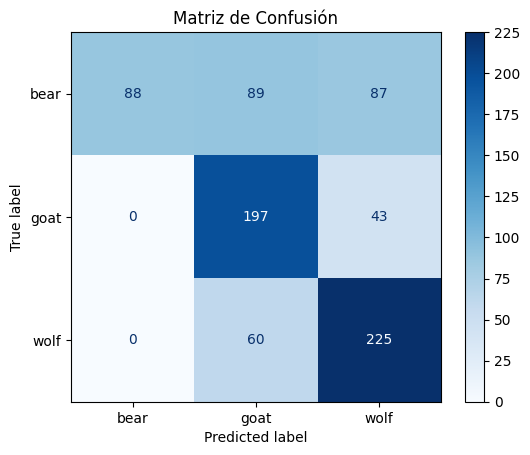

In [279]:
modelo_cargado = load_model("modeloEva2.h5")

# Realizamos las predicciones sobre todo el conjunto de datos (X, y) ya cargado
Y_pred = modelo_cargado.predict(X, batch_size=32)
y_pred = np.argmax(Y_pred, axis=1)

# Obtener las etiquetas verdaderas
y_true = np.argmax(y, axis=1)  # Convertir las etiquetas categóricas a valores enteros

# Crear y mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bear', 'goat', 'wolf'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

In [280]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1

In [281]:
y_pred

array([0, 2, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1,
       2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 2, 0,
       1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0,
       2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 2, 2, 0, 1,
       1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1,
       0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0,
       2, 2, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1,

In [282]:
X_test[5]

array([[[0.13333333, 0.14117647, 0.12941176],
        [0.13333333, 0.14117647, 0.12941176],
        [0.12156863, 0.13333333, 0.12156863],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ]],

       [[0.11764706, 0.12941176, 0.11372549],
        [0.11764706, 0.12941176, 0.10588235],
        [0.10980392, 0.12156863, 0.09803922],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ]],

       [[0.10196078, 0.11372549, 0.09803922],
        [0.10196078, 0.11764706, 0.07843137],
        [0.09803922, 0.11372549, 0.07843137],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.00392157, 0.00392157, 0.00392157]],

       ...,

       [[0.17254902, 0.12156863, 0.05882353],
        [0.19215686, 0.14901961, 0.07058824],
        [0.21568627, 0

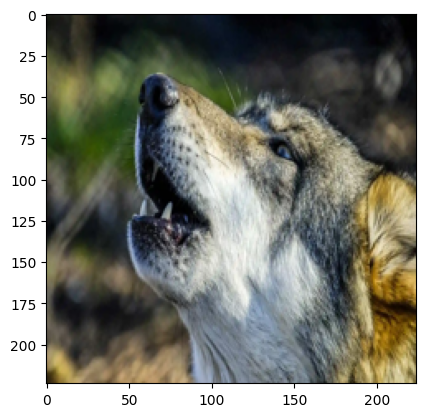

In [283]:

img_array = (X_test[5] * 255).astype(np.uint8)  
img = Image.fromarray(img_array)
plt.imshow(img)

In [289]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import tkinter as tk
from tkinter import filedialog
from sklearn.metrics import accuracy_score

# Cargar el modelo guardado
modelo = load_model('best_model.keras')

# Diccionario de etiquetas
etiquetas = {0: 'Bear', 1: 'Goat', 2: 'Wolf'}

# Función para seleccionar y clasificar una imagen del escritorio
def clasificar_imagen():
    # Seleccionar una imagen desde el escritorio
    root = tk.Tk()
    root.withdraw()  # Cerrar la ventana raíz
    archivo_imagen = filedialog.askopenfilename(title="Selecciona una imagen",
                                                filetypes=[("Archivos de imagen", "*.jpg;*.jpeg;*.png")])
    if archivo_imagen:
        # Cargar y preprocesar la imagen
        imagen = Image.open(archivo_imagen).convert('RGB')
        imagen = imagen.resize((224, 224))  # Redimensionar a 224x224
        imagen_array = img_to_array(imagen) / 255.0  # Normalizar
        imagen_array = np.expand_dims(imagen_array, axis=0)  # Agregar una dimensión

        # Realizar la predicción
        prediccion = modelo.predict(imagen_array)
        categoria = np.argmax(prediccion)  # Clase predicha
        etiqueta = etiquetas[categoria]
        
        # Mostrar la predicción y la precisión
        print(f"La imagen seleccionada es clasificada como: {etiqueta}")
        print(f"Precisión de la predicción: {np.max(prediccion) * 100:.2f}%")
    else:
        print("No se seleccionó ninguna imagen.")

# Ejecuta la función para clasificar la imagen
clasificar_imagen()


1/1 [==============================] - 0s 49ms/step
La imagen seleccionada es clasificada como: Bear
Precisión de la predicción: 72.18%
